In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [2]:
# LOAD ROBOT
robot = loadKinton()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [3]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [1]
    wBaseOri  = [1]
    wArmPos   = [1]
    wBaseVel  = [10]
    wBaseRate = [10]
    wArmVel   = [10] 
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wArmPos * (robot.model.nv - 6) + wBaseVel * robot.model.nv)
    controlWeights = np.array([0.1]*4 + [100]*6)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu =actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                    np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
    runningCostModel.addCost(name="limu", weight=1e-3, cost=uLimCost)
    terminalCostModel.addCost(name="pos", weight=10, cost=goalTrackingCost)

    # DIFFERENTIAL ACTION MODEL
    dmodel = DifferentialActionModelUAM(rmodel, actModel, runningCostModel)
    model = IntegratedActionModelEuler(dmodel)
    model.timeStep =  integrationStep  
    return model   

In [4]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 5e-2

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 25


# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [5]:
models = []
for i in range(0,len(target_pos)):
#    if (i==1):
#        T *=2
    models += [uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')]*T

q0 = rmodel.referenceConfigurations["initial_pose"]
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.67251e-01  4.20441e-02  8.76805e+00  1.00000e-09  1.00000e-09   1.0000     1
   1  5.55684e-01  3.58469e-04  2.99271e-01  1.00000e-09  1.00000e-09   0.0625     1
   2  5.31309e-01  3.20341e-04  2.39454e-01  1.00000e-09  1.00000e-09   0.1250     1
   3  4.97230e-01  2.51906e-04  1.73594e-01  1.00000e-09  1.00000e-09   0.2500     1
   4  4.68044e-01  1.74315e-04  1.00853e-01  1.00000e-09  1.00000e-09   1.0000     1
   5  4.65799e-01  6.36329e-05  5.31715e-02  1.00000e-09  1.00000e-09   0.5000     1
   6  4.51048e-01  5.56021e-05  4.73253e-02  1.00000e-09  1.00000e-09   0.5000     1
   7  4.44854e-01  2.33241e-05  1.81715e-02  1.00000e-09  1.00000e-09   0.5000     1
   8  4.44295e-01  1.05396e-05  6.67558e-03  1.00000e-09  1.00000e-09   0.1250     1
   9  4.42921e-01  7.87399e-06  4.86690e-03  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  4.42520e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  array([ 3.29449644e-07,  1.63660054e-04,  3.09880729e-02, -5.65126477e-03,
          1.13741448e-05,  2.02669533e-07,  9.99984031e-01,  1.69754705e-05,
         -1.43469196e-02,  7.03532505e-05,  3.34424866e-05,  7.59222065e-06,
         -3.08530834e-03, -4.59944556e-07, -2.29288498e-04,  6.19773357e-01,
         -2.26051794e-01,  4.54968213e-04,  8.10682447e-06,  3.39509410e-04,
         -2.86938391e-01,  1.40706501e-03,  6.68849733e-04,  1.51844413e-04,
         -6.17061667e-02]),
  array([ 1.70307596e-06,  1.05067791e-03,  8.67033339e-02, -1.18028131e-02,
          1.60772680e-05, -1.12760134e-06,  9.99930344e-01,  3.43543505e-05,
         -2.78309916e-02,  1.43433192e-04,  7.36477075e-05,  2.31722477e-05,
         -6.01418829e-03, -3.12894729e-06, -1.71087723e-03,  1.11445215e+00,
         -2.46071690e-01,  1.88498116e-04, -5.49454968e-05,  3.47577601e-04,
     

In [6]:
displayTrajectory(robot, ddp.xs, dt)


In [14]:
np.size(ddp.xs,0)

50

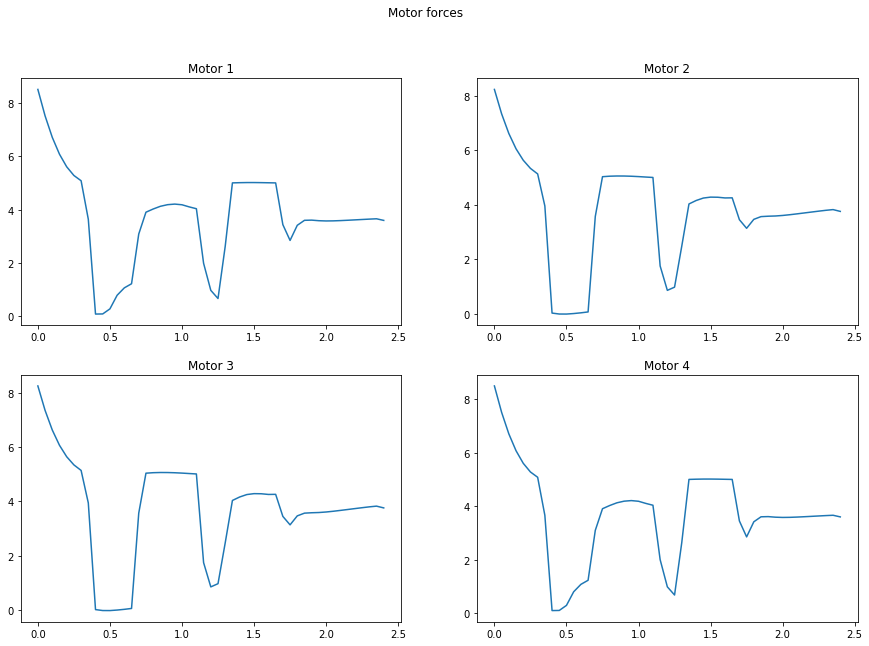

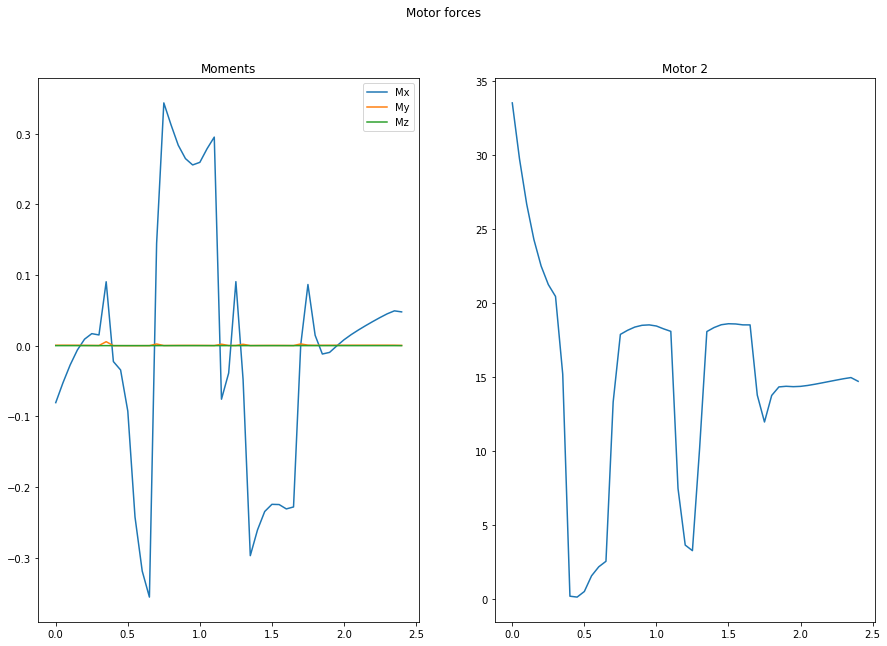

In [17]:
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
pltUAM = PlotUAM(ddp.xs, ddp.us, np.size(ddp.us,0), dt, distanceRotorCOG, cf, cm)

fig, axs = pltUAM.plotMotorForces()
fig,axs = pltUAM.plotActuation()

AttributeError: 'list' object has no attribute 'set_title'

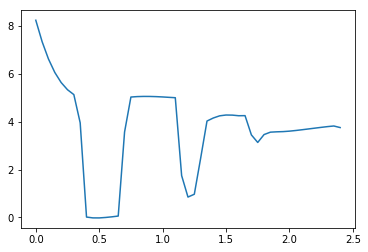

In [32]:
t = np.arange(0, 2*T*dt-dt, dt)
control = np.vstack(ddp.us)
fig = plt.figure()
axs = plt.plot(t, control[:,1])
axs.set_title('Moments')